In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import csv
import seaborn as sns
from scipy.special import erf

sns.set(style="whitegrid",font_scale=1.2)

In [27]:
# Read in the establishment probabilities and fitnesses
pest_all = pd.read_csv('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/pest_all.csv', index_col = 0)
fitness_all = pd.read_csv('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/fitness_all.csv', index_col = 0)

genotypes_filename = '/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/genotypes_order.csv'
genotypes = pd.read_csv(genotypes_filename, names = ['genotype'])

<ipython-input-33-da591a462abf>:24: RuntimeWarning: invalid value encountered in less
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-33-da591a462abf>:24: RuntimeWarning: invalid value encountered in greater
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-33-da591a462abf>:24: RuntimeWarning: invalid value encountered in less
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-33-da591a462abf>:24: RuntimeWarning: invalid value encountered in greater
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-33-da591a462abf>:24: RuntimeWarning: invalid value encountered in less
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-33-da591a462abf>:24: RuntimeWarnin

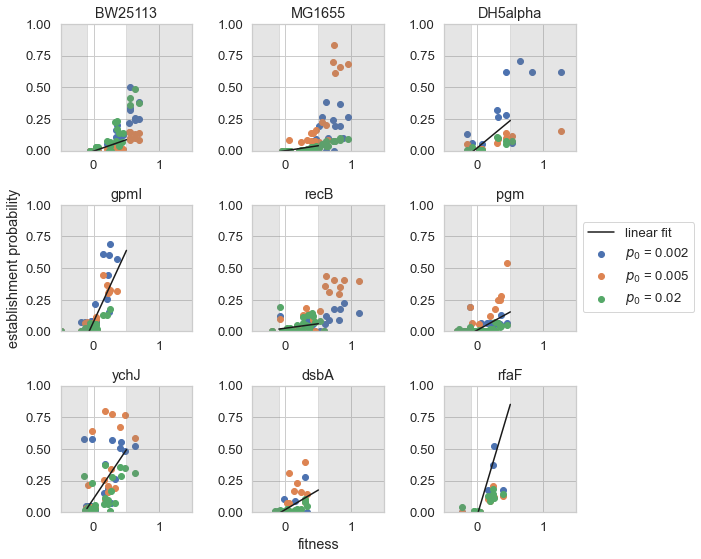

In [33]:
# Fit linear relationship between s = -0.1 and 0.5, using all p0

# Get the neutral data to compare to
filename = '/Users/qinqinyu/Documents/hallatscheck_lab/scripts/keio_collection/validation.csv'
df_validation = pd.read_csv(filename)
fits = pd.DataFrame(columns = ['genotype', 's0.05', 's0.1', 's0.2', 's0.05_err', 's0.1_err', 's0.2_err'])

s = [0.05, 0.1, 0.15, 0.2]

fig, ax = plt.subplots(3, 3, figsize = (10, 8))

i = 0
j = 0

for genotype in genotypes['genotype'].values:
    fitness = fitness_all[fitness_all['genotype']==genotype]
    fitness_tiled = np.tile(fitness['s'].values, 3)
    pest = pest_all[pest_all['genotype']==genotype]
    pest_p0_002 = pest[pest['p0_expected'] == 0.002]['pest'].values#/(1-pest[pest['p0_expected'] == 0.002]['p0_actual'].values)
    pest_p0_005 = pest[pest['p0_expected'] == 0.005]['pest'].values#/(1-pest[pest['p0_expected'] == 0.005]['p0_actual'].values)
    pest_p0_020 = pest[pest['p0_expected'] == 0.020]['pest'].values#/(1-pest[pest['p0_expected'] == 0.020]['p0_actual'].values)
    pest_ordered = np.concatenate((pest_p0_002, pest_p0_005, pest_p0_020))
    
    idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))

    x = fitness_tiled[idx]
    y = pest_ordered[idx]
    
    if len(x)>0:
        z, cov = np.polyfit(x, y, 1, full = False, cov = True)
        zerr = np.sqrt(np.diag(cov))
        p = np.poly1d(z)
        ppp = np.poly1d(z + zerr)
        pmm = np.poly1d(z - zerr)
        ppm = np.poly1d(z + np.array([1, -1])*zerr)
        pmp = np.poly1d(z + np.array([-1, 1])*zerr)
        
        dpp = ppp(s)
        dmm = pmm(s)
        dpm = ppm(s)
        dmp = pmp(s)

        d = np.array([dpp, dmm, dpm, dmp])
        dmax = np.max(d, axis = 0)
        dmin = np.min(d, axis = 0)
        
        err = (dmax-dmin)/2
        
        xfit = np.linspace(-0.1, 0.5, 10)
        fit = pd.DataFrame([np.append(np.append(genotype, p(s)),err)], columns = ['genotype', 's0.05', 's0.1', 's0.15', 's0.2', 's0.05_err', 's0.1_err', 's0.15_err', 's0.2_err'])
        fits = fits.append(fit)
        
        if ~np.isnan(z[0]):
            ax[i,j].scatter(fitness['s'], pest_p0_002, label = '$p_0$ = 0.002')# + str(round(pest[pest['p0_expected'] == 0.002]['p0_actual'].values[0], 4)))
            ax[i,j].scatter(fitness['s'], pest_p0_005, label = '$p_0$ = 0.005')# + str(round(pest[pest['p0_expected'] == 0.005]['p0_actual'].values[0], 4)))
            ax[i,j].scatter(fitness['s'], pest_p0_020, label = '$p_0$ = 0.02')# + str(round(pest[pest['p0_expected'] == 0.020]['p0_actual'].values[0], 4)))

            ax[i,j].plot(xfit, p(xfit), 'k-', label = 'linear fit')

            ax[i,j].fill_between([-0.5, -0.1], 0, 1, color = 'gray', alpha = 0.2)
            ax[i,j].fill_between([0.5, 1.5], 0, 1, color = 'gray', alpha = 0.2)
            ax[i,j].set_xlim([-0.5, 1.5])
            ax[i,j].set_ylim([0, 1])
            ax[i,j].set_title(genotype)
    
            if (j+1)%3 == 0:
                i += 1
                j = 0
            else:
                j += 1
fits.reset_index(inplace = True, drop = True)

ax[2,1].set_xlabel('fitness')
ax[1,0].set_ylabel('establishment probability')

ax[1,2].legend(loc = (1.05, 0.15))
plt.tight_layout()

# plt.savefig('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/all_genotypes_fit.png')
# plt.savefig('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/all_genotypes_fit.pdf')
plt.show()

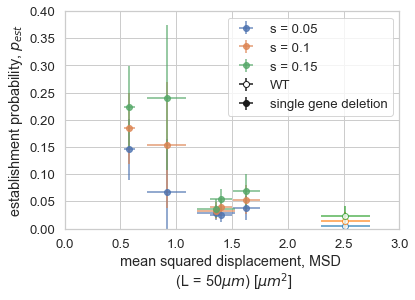

In [34]:
# Plotting only Keio collection strains

merged = df_validation.merge(fits, on = 'genotype')

merged_nowt = merged[(merged['genotype'] != 'BW25113') & (merged['genotype'] != 'DH5alpha') & (merged['genotype'] != 'MG1655')]
merged_wt = merged[merged['genotype'] == 'BW25113']

plt.errorbar(merged_nowt['MSD (L = 50um)'].values.astype('float'), merged_nowt['s0.05'].values.astype('float'), yerr = merged_nowt['s0.05_err'].values.astype('float'), xerr = merged_nowt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', label = 's = 0.05', alpha = 0.8)
plt.errorbar(merged_nowt['MSD (L = 50um)'].values.astype('float'), merged_nowt['s0.1'].values.astype('float'), yerr = merged_nowt['s0.1_err'].values.astype('float'), xerr = merged_nowt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', label = 's = 0.1', alpha = 0.8)
plt.errorbar(merged_nowt['MSD (L = 50um)'].values.astype('float'), merged_nowt['s0.15'].values.astype('float'), yerr = merged_nowt['s0.15_err'].values.astype('float'), xerr = merged_nowt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', label = 's = 0.15', alpha = 0.8)

plt.errorbar(merged_wt['MSD (L = 50um)'].values.astype('float'), merged_wt['s0.05'].values.astype('float'), yerr = merged_wt['s0.05_err'].values.astype('float'), xerr = merged_wt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', mec = 'tab:blue', mfc = 'white', color = 'tab:blue', alpha = 0.8)
plt.errorbar(merged_wt['MSD (L = 50um)'].values.astype('float'), merged_wt['s0.1'].values.astype('float'), yerr = merged_wt['s0.1_err'].values.astype('float'), xerr = merged_wt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', mec = 'tab:orange',  mfc = 'white', color = 'tab:orange', alpha = 0.8)
plt.errorbar(merged_wt['MSD (L = 50um)'].values.astype('float'), merged_wt['s0.15'].values.astype('float'), yerr = merged_wt['s0.15_err'].values.astype('float'), xerr = merged_wt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', mec = 'tab:green',  mfc = 'white', color = 'tab:green', alpha = 0.8)

D = np.logspace(-3, 1, 100)
phi0 = 2*10**-2
L = 50 # microns
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.errorbar([], [], yerr = [], xerr = [], marker = 'o', color = 'k', mfc = 'white', mec = 'k', linestyle = '', label = 'WT')
plt.errorbar([], [], yerr = [], xerr = [], marker = 'o', color = 'k', linestyle = '', label = 'single gene deletion')

plt.legend()
plt.xlim([0, 3])
plt.ylim([0, 0.4])
plt.xlabel('mean squared displacement, MSD \n (L = 50$\mu m$) [$\mu m^2$]')
plt.ylabel('establishment probability, $p_{est}$')
# plt.tight_layout()
# plt.savefig('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/pest_msd_keio_intermediate_s_v2.png')
# plt.savefig('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/pest_msd_keio_intermediate_s_v2.pdf')
plt.show()

In [35]:
# Save the data
merged_nowt.to_csv('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/correct_heterozygosity/keio_deletions_uncorrected.csv')

In [36]:
# Repeat, but now correct for the heterozygosity:
# pest = pest/(1-p0_actual) 
# pest = establishment probability
# p0_actual = measured initial fraction of mutants in the inoculum

# This corrects for the probability that a mutant sector actually started from more than 1 mutant cell in
# in the inoculum. This is done by dividing the establishment probability by the probability that a 
# mutant cell in the inoculum is next to a wild type cell

<ipython-input-37-2832276c0c58>:24: RuntimeWarning: invalid value encountered in less
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-37-2832276c0c58>:24: RuntimeWarning: invalid value encountered in greater
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-37-2832276c0c58>:24: RuntimeWarning: invalid value encountered in less
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-37-2832276c0c58>:24: RuntimeWarning: invalid value encountered in greater
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-37-2832276c0c58>:24: RuntimeWarning: invalid value encountered in less
  idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))
<ipython-input-37-2832276c0c58>:24: RuntimeWarnin

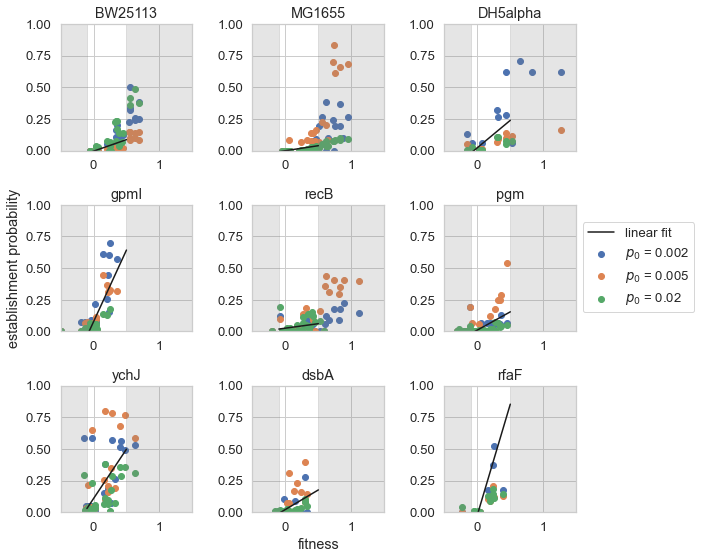

In [37]:
# Fit linear relationship between s = -0.1 and 0.5, using all p0

# Get the neutral data to compare to
filename = '/Users/qinqinyu/Documents/hallatscheck_lab/scripts/keio_collection/validation.csv'
df_validation = pd.read_csv(filename)
fits = pd.DataFrame(columns = ['genotype', 's0.05', 's0.1', 's0.2', 's0.05_err', 's0.1_err', 's0.2_err'])

s = [0.05, 0.1, 0.15, 0.2]

fig, ax = plt.subplots(3, 3, figsize = (10, 8))

i = 0
j = 0

for genotype in genotypes['genotype'].values:
    fitness = fitness_all[fitness_all['genotype']==genotype]
    fitness_tiled = np.tile(fitness['s'].values, 3)
    pest = pest_all[pest_all['genotype']==genotype]
    pest_p0_002 = pest[pest['p0_expected'] == 0.002]['pest'].values/(1-pest[pest['p0_expected'] == 0.002]['p0_actual'].values)
    pest_p0_005 = pest[pest['p0_expected'] == 0.005]['pest'].values/(1-pest[pest['p0_expected'] == 0.005]['p0_actual'].values)
    pest_p0_020 = pest[pest['p0_expected'] == 0.020]['pest'].values/(1-pest[pest['p0_expected'] == 0.020]['p0_actual'].values)
    pest_ordered = np.concatenate((pest_p0_002, pest_p0_005, pest_p0_020))
    
    idx = np.logical_and(np.logical_and(fitness_tiled<0.5, fitness_tiled>-0.1), ~np.isnan(pest_ordered))

    x = fitness_tiled[idx]
    y = pest_ordered[idx]
    
    if len(x)>0:
        z, cov = np.polyfit(x, y, 1, full = False, cov = True)
        zerr = np.sqrt(np.diag(cov))
        p = np.poly1d(z)
        ppp = np.poly1d(z + zerr)
        pmm = np.poly1d(z - zerr)
        ppm = np.poly1d(z + np.array([1, -1])*zerr)
        pmp = np.poly1d(z + np.array([-1, 1])*zerr)
        
        dpp = ppp(s)
        dmm = pmm(s)
        dpm = ppm(s)
        dmp = pmp(s)

        d = np.array([dpp, dmm, dpm, dmp])
        dmax = np.max(d, axis = 0)
        dmin = np.min(d, axis = 0)
        
        err = (dmax-dmin)/2
        
        xfit = np.linspace(-0.1, 0.5, 10)
        fit = pd.DataFrame([np.append(np.append(genotype, p(s)),err)], columns = ['genotype', 's0.05', 's0.1', 's0.15', 's0.2', 's0.05_err', 's0.1_err', 's0.15_err', 's0.2_err'])
        fits = fits.append(fit)
        
        if ~np.isnan(z[0]):
            ax[i,j].scatter(fitness['s'], pest_p0_002, label = '$p_0$ = 0.002')# + str(round(pest[pest['p0_expected'] == 0.002]['p0_actual'].values[0], 4)))
            ax[i,j].scatter(fitness['s'], pest_p0_005, label = '$p_0$ = 0.005')# + str(round(pest[pest['p0_expected'] == 0.005]['p0_actual'].values[0], 4)))
            ax[i,j].scatter(fitness['s'], pest_p0_020, label = '$p_0$ = 0.02')# + str(round(pest[pest['p0_expected'] == 0.020]['p0_actual'].values[0], 4)))

            ax[i,j].plot(xfit, p(xfit), 'k-', label = 'linear fit')

            ax[i,j].fill_between([-0.5, -0.1], 0, 1, color = 'gray', alpha = 0.2)
            ax[i,j].fill_between([0.5, 1.5], 0, 1, color = 'gray', alpha = 0.2)
            ax[i,j].set_xlim([-0.5, 1.5])
            ax[i,j].set_ylim([0, 1])
            ax[i,j].set_title(genotype)
    
            if (j+1)%3 == 0:
                i += 1
                j = 0
            else:
                j += 1
fits.reset_index(inplace = True, drop = True)

ax[2,1].set_xlabel('fitness')
ax[1,0].set_ylabel('establishment probability')

ax[1,2].legend(loc = (1.05, 0.15))
plt.tight_layout()

# plt.savefig('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/figures/all_genotypes_fit_correct_heterozygosity.png')
# plt.savefig('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/figures/all_genotypes_fit_correct_heterozygosity.pdf')
plt.show()

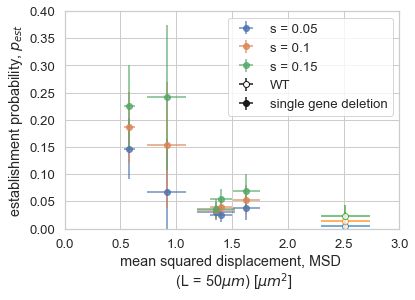

In [38]:
# Plotting only Keio collection strains

merged = df_validation.merge(fits, on = 'genotype')

merged_nowt = merged[(merged['genotype'] != 'BW25113') & (merged['genotype'] != 'DH5alpha') & (merged['genotype'] != 'MG1655')]
merged_wt = merged[merged['genotype'] == 'BW25113']

plt.errorbar(merged_nowt['MSD (L = 50um)'].values.astype('float'), merged_nowt['s0.05'].values.astype('float'), yerr = merged_nowt['s0.05_err'].values.astype('float'), xerr = merged_nowt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', label = 's = 0.05', alpha = 0.8)
plt.errorbar(merged_nowt['MSD (L = 50um)'].values.astype('float'), merged_nowt['s0.1'].values.astype('float'), yerr = merged_nowt['s0.1_err'].values.astype('float'), xerr = merged_nowt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', label = 's = 0.1', alpha = 0.8)
plt.errorbar(merged_nowt['MSD (L = 50um)'].values.astype('float'), merged_nowt['s0.15'].values.astype('float'), yerr = merged_nowt['s0.15_err'].values.astype('float'), xerr = merged_nowt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', label = 's = 0.15', alpha = 0.8)

plt.errorbar(merged_wt['MSD (L = 50um)'].values.astype('float'), merged_wt['s0.05'].values.astype('float'), yerr = merged_wt['s0.05_err'].values.astype('float'), xerr = merged_wt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', mec = 'tab:blue', mfc = 'white', color = 'tab:blue', alpha = 0.8)
plt.errorbar(merged_wt['MSD (L = 50um)'].values.astype('float'), merged_wt['s0.1'].values.astype('float'), yerr = merged_wt['s0.1_err'].values.astype('float'), xerr = merged_wt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', mec = 'tab:orange',  mfc = 'white', color = 'tab:orange', alpha = 0.8)
plt.errorbar(merged_wt['MSD (L = 50um)'].values.astype('float'), merged_wt['s0.15'].values.astype('float'), yerr = merged_wt['s0.15_err'].values.astype('float'), xerr = merged_wt['MSD ste (L = 50um)'].values.astype('float'), linestyle = '', marker = 'o', mec = 'tab:green',  mfc = 'white', color = 'tab:green', alpha = 0.8)

D = np.logspace(-3, 1, 100)
phi0 = 2*10**-2
L = 50 # microns
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.errorbar([], [], yerr = [], xerr = [], marker = 'o', color = 'k', mfc = 'white', mec = 'k', linestyle = '', label = 'WT')
plt.errorbar([], [], yerr = [], xerr = [], marker = 'o', color = 'k', linestyle = '', label = 'single gene deletion')

plt.legend()
plt.xlim([0, 3])
plt.ylim([0, 0.4])
plt.xlabel('mean squared displacement, MSD \n (L = 50$\mu m$) [$\mu m^2$]')
plt.ylabel('establishment probability, $p_{est}$')
# plt.tight_layout()
plt.savefig('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/figures/pest_msd_keio_intermediate_s_v2_correct_heterozygosity.png')
plt.savefig('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/figures/pest_msd_keio_intermediate_s_v2_correct_heterozygosity.pdf')
plt.show()

In [39]:
# Save the data
merged_nowt.to_csv('/Users/qinqinyu/Dropbox (Personal)/keio_data/nonneutral_data/correct_heterozygosity/keio_deletions_corrected.csv')

In [4]:
# Plot the establishment probability as a function of initial mutant fraction

pest_p0 = pd.read_csv('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/pest_separate_p0.csv', index_col = 0)

['BW25113' 'DH5alpha' 'MG1655' 'dsbA' 'gpmI' 'pgm' 'recB' 'rfaF' 'tatB'
 'ychJ']


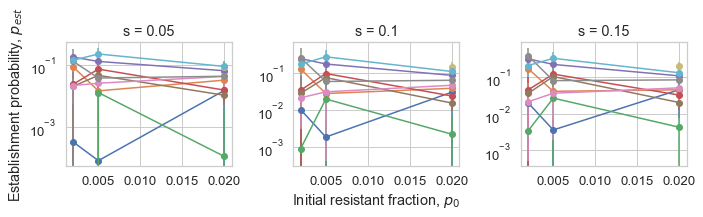

In [71]:
# pest_p0.plot(x='p0',y='s0.05')
genotypes = np.unique(pest_p0['genotype'])
print(genotypes)
fig,ax = plt.subplots(1,3,figsize = (10,3))
for genotype in genotypes:
    pest_p0_gene = pest_p0[pest_p0['genotype']==genotype]
    ax[0].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.05'], yerr = pest_p0_gene['s0.05_err'], marker = 'o')
    ax[1].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.1'], yerr = pest_p0_gene['s0.1_err'], marker = 'o')
    ax[2].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.15'], yerr = pest_p0_gene['s0.15_err'], marker = 'o')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_title('s = 0.05')
ax[1].set_title('s = 0.1')
ax[2].set_title('s = 0.15')

ax[1].set_xlabel('Initial resistant fraction, $p_0$')
ax[0].set_ylabel('Establishment probability, $p_{est}$')
plt.tight_layout()

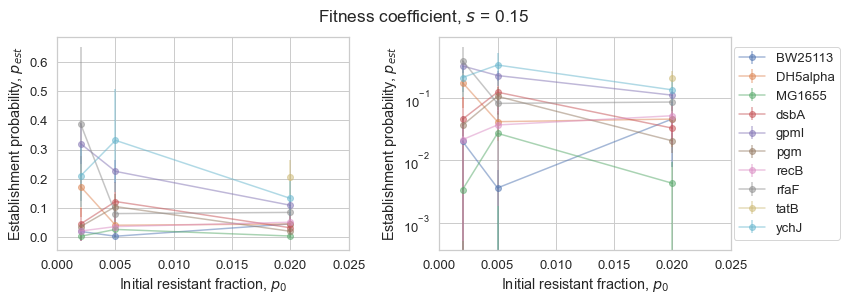

In [77]:
genotypes = np.unique(pest_p0['genotype'])
fig, ax = plt.subplots(1, 2, figsize=(12,4))
for genotype in genotypes:
    pest_p0_gene = pest_p0[pest_p0['genotype']==genotype]
    ax[0].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.15'], yerr = pest_p0_gene['s0.15_err'], marker = 'o', alpha = 0.5, label = genotype)
    ax[1].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.15'], yerr = pest_p0_gene['s0.15_err'], marker = 'o', alpha = 0.5, label = genotype)

ax[1].set_yscale('log')
ax[0].set_xlim(0, 0.025)
ax[1].set_xlim(0, 0.025)

ax[1].legend(loc = (1.01, 0.05))

fig.suptitle('Fitness coefficient, $s$ = 0.15', y = 1.05)
ax[0].set_xlabel('Initial resistant fraction, $p_0$')
ax[1].set_xlabel('Initial resistant fraction, $p_0$')

ax[0].set_ylabel('Establishment probability, $p_{est}$')
ax[1].set_ylabel('Establishment probability, $p_{est}$')

plt.tight_layout()
plt.savefig("/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/pest_p0_s0.15.pdf")
plt.savefig("/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/pest_p0_s0.15.png", dpi = 300)

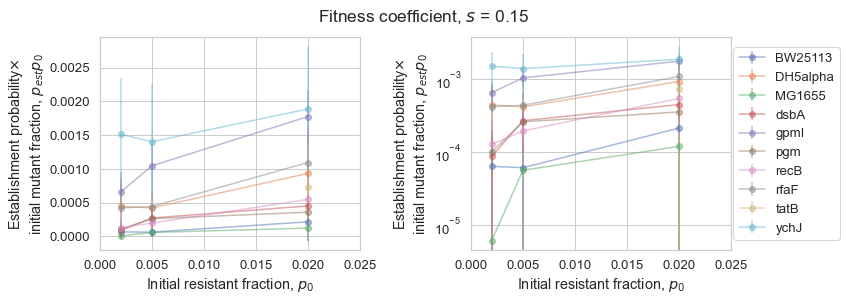

In [154]:
genotypes = np.unique(pest_p0['genotype'])
fig, ax = plt.subplots(1, 2, figsize=(12,4))
for genotype in genotypes:
    pest_p0_gene = pest_p0[pest_p0['genotype']==genotype]
    yerr = pest_p0_gene['s0.15']*pest_p0_gene['p0_actual']*np.sqrt((pest_p0_gene['s0.15_err']/pest_p0_gene['s0.15'])**2 + (pest_p0_gene['p0_actual_err']/pest_p0_gene['p0_actual'])**2)
    ax[0].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.15']*pest_p0_gene['p0_actual'], yerr = yerr, marker = 'o', alpha = 0.5, label = genotype)
    ax[1].errorbar(pest_p0_gene['p0'], pest_p0_gene['s0.15']*pest_p0_gene['p0_actual'], yerr = yerr, marker = 'o', alpha = 0.5, label = genotype)

ax[1].set_yscale('log')
ax[0].set_xlim(0, 0.025)
ax[1].set_xlim(0, 0.025)

ax[1].legend(loc = (1.01, 0.05))

fig.suptitle('Fitness coefficient, $s$ = 0.15', y = 1.05)
ax[0].set_xlabel('Initial resistant fraction, $p_0$')
ax[1].set_xlabel('Initial resistant fraction, $p_0$')

ax[0].set_ylabel('Establishment probability$\\times$\ninitial mutant fraction, $p_{est}p_0$')
ax[1].set_ylabel('Establishment probability$\\times$\ninitial mutant fraction, $p_{est}p_0$')

plt.tight_layout()
plt.savefig("/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/sectors_p0_s0.15.pdf")
plt.savefig("/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/sectors_p0_s0.15.png", dpi = 300)

In [155]:
# Plot number of sectors against the initial mutant fraction
sectors = pd.read_csv('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/pest_all_num_sectors.csv', index_col = 0)
fitness = pd.read_csv('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/fitness_all.csv', index_col = 0)

In [156]:
pest_all = pd.DataFrame(columns = ['genotype', 'cm', 'fitness', 'fitness_err', 'p0_expected', 'p0_actual', 'p0_actual_err', 'num_sectors', 'num_sectors_err'])

cm_all =[0, 1, 2, 3]
genotypes = np.unique(sectors['genotype'])
for genotype in genotypes:
    for cm in cm_all:
        cond1 = fitness['genotype']==genotype
        cond2 = fitness['cm'] == cm
        fitness_mean = np.nanmean(fitness[cond1&cond2]['s'])
        fitness_std = np.nanstd(fitness[cond1&cond2]['s'])
        p0_all = [0.002, 0.005, 0.02]
        sectors_gene = sectors[sectors['genotype'] == genotype]
        sectors_gene_cm = sectors_gene[sectors_gene['cm']==cm]

        for i in range(len(p0_all)):
            p0 = p0_all[i]
            p0_actual = sectors_gene_cm[sectors_gene_cm['p0_expected']==p0]['p0_actual'].values[0]
            p0_actual_err = sectors_gene_cm[sectors_gene_cm['p0_expected']==p0]['p0_actual_err'].values[0]
            sectors_mean = np.mean(sectors_gene_cm[sectors_gene_cm['p0_expected']==p0]['num_sectors'])
            sectors_std = np.std(sectors_gene_cm[sectors_gene_cm['p0_expected']==p0]['num_sectors'])

            pest_data = {'genotype':[genotype], 'cm':[cm], 'fitness':[fitness_mean], 'fitness_err':[fitness_std], 'p0_expected':[p0], 'p0_actual':[p0_actual], 'p0_actual_err':[p0_actual_err], 'num_sectors':[sectors_mean], 'num_sectors_err':[sectors_std]}
            pest = pd.DataFrame(pest_data)

            pest_all = pest_all.append(pest)
pest_all.reset_index(inplace = True, drop = True)

<ipython-input-156-9fd8e20f70ad>:9: RuntimeWarning: Mean of empty slice
  fitness_mean = np.nanmean(fitness[cond1&cond2]['s'])
/Users/qinqinyu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


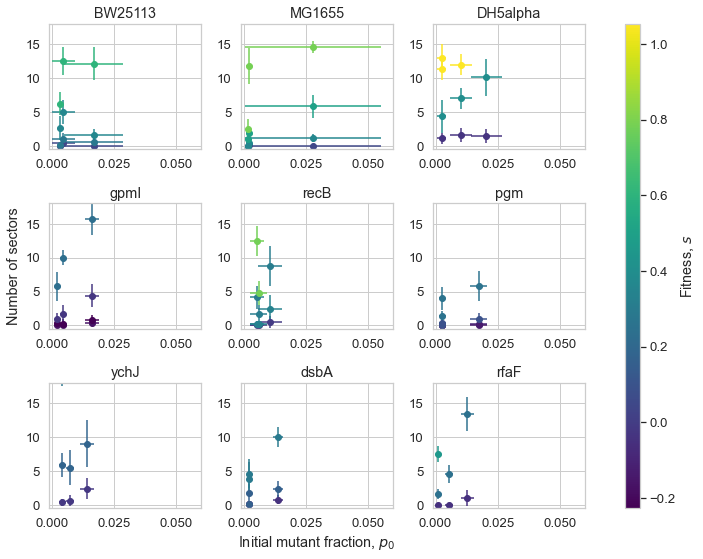

In [157]:
import matplotlib as mpl
from matplotlib import cm

fig, ax = plt.subplots(3, 4, figsize = (10,8), gridspec_kw = {'width_ratios':[10,10,10,1]})
gs = ax[0,2].get_gridspec()
for a in ax[:,-1]:
    a.remove()
axbig = fig.add_subplot(gs[:,-1])

genotypes = ['BW25113', 'MG1655', 'DH5alpha', 'gpmI', 'recB', 'pgm', 'ychJ', 'dsbA', 'rfaF']
i = 0
j = 0
fitness_max = np.max(pest_all['fitness'])
fitness_min = np.min(pest_all['fitness'])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array-value))
    return idx, array[idx]

cmap = cm.viridis
norm = mpl.colors.Normalize(vmin = fitness_min, vmax = fitness_max)

for genotype in genotypes:
    for cm in cm_all:
        cond1 = pest_all['genotype'] == genotype
        cond2 = pest_all['cm'] == cm
        pest_subset = pest_all[cond1&cond2]
        fitness_rescaled = (pest_subset['fitness'].values[0]-fitness_min)/(fitness_max-fitness_min)
        cmap_current = cmap(fitness_rescaled)
        if ~np.isnan(fitness_rescaled):
            ax[i, j].errorbar(pest_subset['p0_actual'], pest_subset['num_sectors'], yerr = pest_subset['num_sectors_err'], xerr = pest_subset['p0_actual_err'],  marker = 'o', linestyle = '', color = cmap_current[:-1])
    ax[i,j].set_title(genotype)
    ax[i,j].set_xlim([-0.001, 0.06])
    ax[i,j].set_ylim([-0.5, 18])
    if (j+1)%3 == 0:
        i += 1
        j = 0
    else:
        j += 1
ax[2,1].set_xlabel('Initial mutant fraction, $p_0$')
ax[1,0].set_ylabel('Number of sectors')

mpl.colorbar.ColorbarBase(axbig, cmap = cmap, orientation = 'vertical', norm = norm)
axbig.set_ylabel('Fitness, $s$')
plt.tight_layout()
plt.savefig('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/sectors_p0_all_s.pdf')
plt.savefig('/Users/qinqinyu/Dropbox/keio_data/nonneutral_data/figures/sectors_p0_all_s.png', dpi = 300)